In [8]:
import olf.spectrum
import numpy as np
from grizli import utils, jwst_utils
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
fname = '/Users/vasily/Documents/projects/uncover_msa/gabe_reductions/raw/uncover-v2_prism-clear_2561_20466.spec.fits'

In [3]:
z_guess = 8.5

delta_z = 0.01
scale_disp = 1.3
zgrid = np.arange(z_guess-.05,z_guess+.05,delta_z)
narrow_grid = np.arange(50,850,50)
broad_grid = np.arange(800,5500,200)
narrow_grid_fp = np.arange(249,250,1)
broad_grid_fp = np.arange(250,251,1)
nspline = 30
broad_lines = ['Hb']
exclude_lines = broad_lines+['Ha+NII']
# custom_range = [1.0,2.6]
custom_range = None # If you only want to fit a small part of the spectrum
 
# Switch method to lstsq to fit with absorption lines

data,sampler = olf.spectrum.fit_spectrum(file=fname,nspline=nspline,zgrid=zgrid,narrow_grid=narrow_grid,broad_grid=broad_grid,broad_lines=broad_lines,
                                           id=id,custom_range=custom_range,unlock_ratios=1,save_data=False,method='nnls',first_pass=0,correct_spectrum=0)

Grating: prism
Fitting a total of 4224 models
Line ratios ignored


11it [00:25,  2.36s/it]

Best chi2 76.6122495885682
Best reduced chi2 0.18284546441185728
Best z 8.499999999999998 +- 0.03999999999999915
FWHM_narrow 50 +- 275.0 km/s
FWHM_broad 3400 +- 1700.0 km/s

# line flux err
# flux x 10^-20 erg/s/cm2
# z = 8.50000
# Fri Jun  7 15:27:06 2024
            line Lya      361.4 ±    186.4 (EW=   3623.6)
      line OIII-1663       28.7 ±    113.8 (EW=    225.1)
      line NIII-1750        0.0 ±      0.0 (EW=      0.0)
      line CIII-1906       64.7 ±     86.9 (EW=   1051.0)
           line MgII       37.4 ±     40.0 (EW=    363.2)
       line NeV-3346        0.0 ±      0.0 (EW=      0.0)
      line NeVI-3426        0.0 ±      0.0 (EW=      0.0)
            line OII       27.7 ±     29.4 (EW=    404.8)
     line NeIII-3867       67.0 ±     26.0 (EW=    870.9)
       line HeI-3889        9.3 ±     26.7 (EW=    114.5)
     line NeIII-3968       30.4 ±     26.3 (EW=    300.2)
             line Hd       18.1 ±     26.5 (EW=    161.3)
             line Hg       36.9 ±     26.7 (EW=

In [4]:
# This adds all high significance lines to the ranges instead of whatever we had there before

def create_line_ranges(data,snr=1.5,delta=20):
    ranges = []
    lines=[]
    lw, lr = utils.get_line_wavelengths()
    for coeff in data['coeffs']:
        if 'line' in coeff:
            try:
                line_snr = data['coeffs'][coeff][0]/data['coeffs'][coeff][1]
            except:
                continue
            if line_snr>snr:
                print(coeff)
                wav = lw[coeff.split()[1]]
                if len(wav)>0:
                    wav = wav[0]
                rng = (wav-delta,wav+delta)
                ranges.append(rng)
                lines.append(coeff.split()[1])

    return ranges,lines

def moving_average(arr,N):
    return np.convolve(arr, np.ones((N,))/N, mode='same') 

line NeIII-3867
line OIII-4363
line Hb
line OIII-4959
line OIII-5007


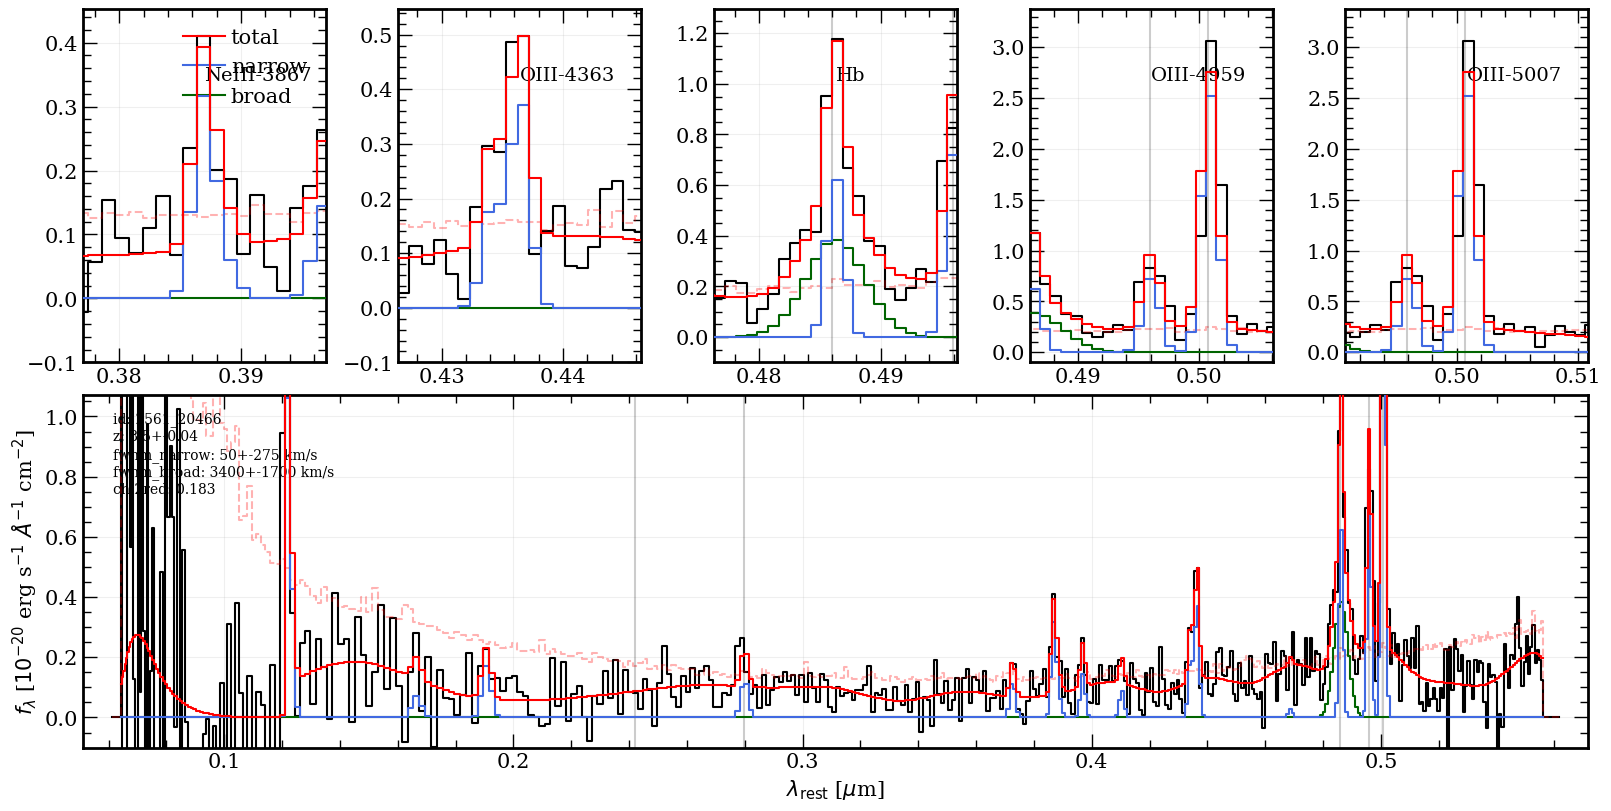

In [12]:
from matplotlib.gridspec import GridSpec
figsize=(16, 8)
# ranges = [(3600,4400),(4100,4600),(4750,5100),(6450,6650)] # Balmer lines
# ranges = [(1530,1570),(1650,1680),(1890,1920),(2400,2440),(2770,2830),(3310,3370)] #Rest-UV lines
# ranges = [(1530,1570),(1650,1680),(1890,1920),(2400,2440),(2770,2830)] #Rest-UV lines
ranges = [(1530,1570),(1650,1680),(1890,1920),(2400,2440),(2770,2830)] #Rest-UV lines redder
# ranges = [(4300,4500),(4750,5100),]

ranges,lines = create_line_ranges(data,snr=2,delta=100)

if len(ranges)>6:
    ranges=ranges[:6]



        


show_splines = 0
rest_frame =1

if len(ranges) > 0:
        fig = plt.figure(figsize=figsize, constrained_layout=True)
        gs = GridSpec(2, len(ranges), figure=fig)
        axes = []
        for i, _ra in enumerate(ranges):
            axes.append(fig.add_subplot(gs[0,i]))
    
        axes.append(fig.add_subplot(gs[1,:]))
        
else:
    fig, ax = plt.subplots(1,1,figsize=figsize)
    axes = [ax]
# snr = np.array(data['flam'])/np.array(data['eflam'])
for ix, ax in enumerate(axes):

    wave = np.copy(data['wave'])
    if rest_frame:
         wave = wave/(1+data['z'])
    ax.step(wave,data['flam'],where='mid',color='k')
    ax.step(wave,data['eflam'],where='mid',color='red',ls='--',alpha=.3)
    # model_full = data['mline_narrow']+data['mline_broad']+data['mcont']
    ax.step(wave,np.array(data['model']),where='mid',color='red',label='total',zorder=40)
    # ax.step(data['wave'],np.array(data['mline']),color='royalblue',where='mid',label='narrow',zorder=30)
    ax.step(wave,np.array(data['mline_narrow'])+0*np.array(data['mcont']),color='royalblue',where='mid',label='narrow',zorder=30)
    ax.step(wave,np.array(data['mline_broad'])+0*np.array(data['mcont']),color='darkgreen',where='mid',label='broad',zorder=20)
    # ax.set_ylim(-1,.5*np.nanmax(data['flam']))
    max = np.percentile(data['flam'],q=[98])
    ax.set_ylim(-.1,.9*max)
    ax.set_xlim(wave[0]-.01,wave[-1]+.01)
    # ax.set_xlim(0.5,1.3)
    ax.grid(alpha=.2)
    # if ix==len(axes):
        # ax.set_ylabel(r'$f_{\lambda}$ [$10^{-20}$ erg s$^{-1}$ $\AA^{-1}$ cm$^{-2}$]')

    # ax.axvline(4102*(1+4.47)/1e4)
    # ax.axvline(3970*(1+4.47)/1e4)
    # ax.axvline(3880*(1+4)/1e4)
    if rest_frame:
        zscl = 0
    else:
        zscl = 1

    ax.axvline(6560.032*(1+zscl*data['z'])/1e4,color='k',alpha=.2)
    ax.axvline(4959*(1+zscl*data['z'])/1e4,color='k',alpha=.2)
    ax.axvline(5007*(1+zscl*data['z'])/1e4,color='k',alpha=.2)
    ax.axvline(2796*(1+zscl*data['z'])/1e4,color='k',alpha=.2)
    ax.axvline(4860*(1+zscl*data['z'])/1e4,color='k',alpha=.2)
    ax.axvline(2420.0*(1+zscl*data['z'])/1e4,color='k',alpha=.2)


if show_splines:
    bspl = sampler.bspline_array(nspline=nspline, get_matrix=True)
    for i,spl in enumerate(bspl):
        ax.plot(wave,data['mcont'][i]*spl,color='darkred',alpha=.5)

          

for i, r in enumerate(ranges):
        bound = [ri*(1+zscl*data['z'])/1.e4 for ri in r]
        mask_bound = (np.array(wave)>bound[0]) & (np.array(wave)<bound[1])
        axes[i].set_xlim(*bound)
        axes[i].text(0.5,0.8,lines[i],fontsize=14,color='k',transform=axes[i].transAxes)
        try:
            axes[i].set_ylim(-.1,1.1*np.max(np.array(data['flam'])[mask_bound]))
        except:
             axes[i].set_ylim(-1,1)

        if i==0:
            axes[i].legend()
       


ax = axes[len(ranges)]
ax.set_ylabel(r'$f_{\lambda}$ [$10^{-20}$ erg s$^{-1}$ $\AA^{-1}$ cm$^{-2}$]')
ax.set_xlabel(r'$\lambda_{\rm obs}$ [$\mu$m]')
if rest_frame:
    ax.set_xlabel(r'$\lambda_{\rm rest}$ [$\mu$m]')

x0 = .02
y0=.92
dy=.05
cntr=0
for i,best_param in enumerate(['id','z','fwhm_narrow','fwhm_broad','chi2red']):
    add = ''
    if i==0:
        text = best_param+': '+str(data[best_param])
        ax.text(x0,y0-cntr*dy,text,size=10,transform=ax.transAxes,color='k')
        cntr+=1
        continue

    if 'fwhm' in best_param:
        add = ' km/s'
    
    # if 'broad' in best_param:
        #  continue
  
    if best_param=='z':
        text = best_param+': '+str(np.round(data[best_param],4))+'+-'+str(np.round(data[f'err_'+best_param],4))
    elif best_param=='chi2red':
         text = best_param+': '+str(np.round(data[best_param],3))
    else:
         text = best_param+': '+str(int(data[best_param]))+'+-'+str(int(data[f'err_'+best_param]))+add


    ax.text(x0,y0-cntr*dy,text,size=10,transform=ax.transAxes,color='k')
    cntr+=1

if 'spec.fits' in data['file']:
    froot = data['file'].split('.spec.fits')[0]
else:
    froot = data['file'].split('.fits')[0]
froot = froot.split('/')[-1]

grating = data['grating']


# ax.axvline(5007*(1+8.35)/1e4)
# ax.axvline(6560*(1+data['z'])/1e4)

# plt.savefig(f'/Users/vasily/Documents/projects/jades_lrd/plots/bl_fits_v2/{data["id"]}_{grating}_msaexp.png')


